<a href="https://colab.research.google.com/github/prikmm/MLprojects/blob/main/notebooks/RNN_concepts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offset1, offset2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offset1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offset2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

callbacks=[keras.callbacks.EarlyStopping(patience=5),
           keras.callbacks.ModelCheckpoint("Best_simple_RNN.h5")]

n_steps = 50

In [3]:
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000, :n_steps], series[9000:, -1]
X_train.shape, y_train.shape

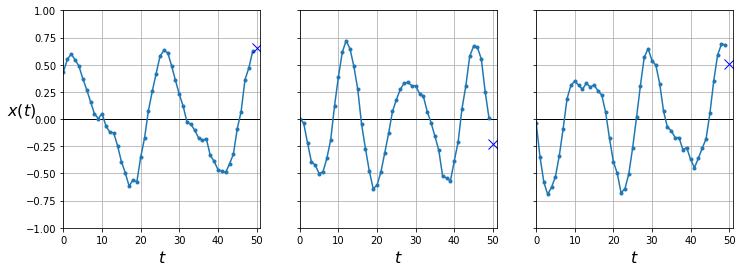

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

### Computing Baseline Metrics:

In [7]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020623494

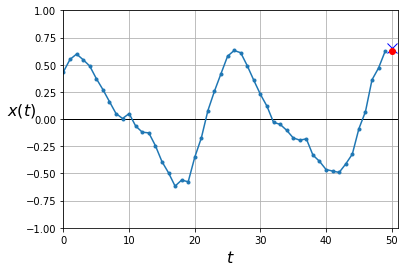

In [8]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [9]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1),
])

model.compile(loss="mse",
              optimizer="nadam",
              metrics=["mse"])
model.summary()

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

model.evaluate(X_valid, y_valid)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


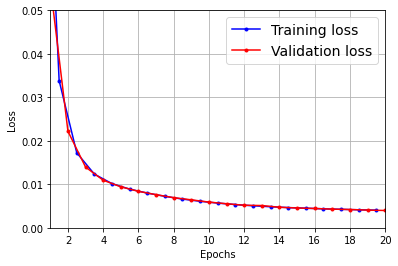

In [12]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

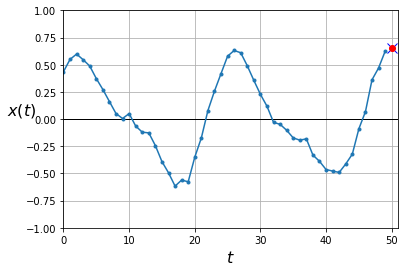

In [13]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Simple RNN:

In [14]:
simple_rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

simple_rnn_model.compile(loss="mse",
              optimizer="nadam",
              metrics=["mse"])

history = simple_rnn_model.fit(X_train, y_train, epochs=50,
                                validation_data=(X_valid, y_valid),
                                callbacks=[keras.callbacks.EarlyStopping(patience=5),
                                            keras.callbacks.ModelCheckpoint("Best_simple_RNN.h5")])

In [16]:
simple_rnn_model = keras.models.load_model("Best_simple_RNN.h5")
simple_rnn_model.summary()
simple_rnn_model.evaluate(X_valid, y_valid)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


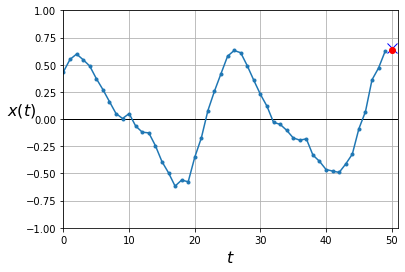

In [18]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [19]:
full_rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1),
])

full_rnn_model.compile(loss="mse",
              optimizer="nadam",
              metrics=["mse"])

history = full_rnn_model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid),
                    callbacks=callbacks)

In [22]:
full_rnn_model = keras.models.load_model("Best_simple_RNN.h5")
full_rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


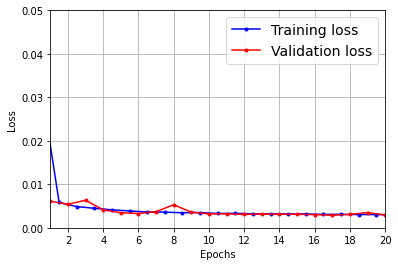

In [23]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [24]:
full_rnn_model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 10ms/step - loss: 0.0034 - mse: 0.0034


[0.0033967746421694756, 0.0033967746421694756]

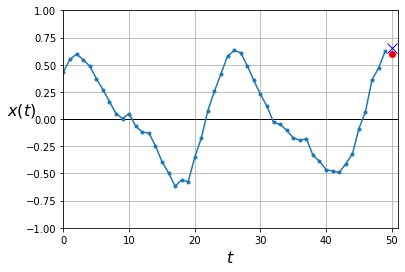

In [25]:
y_pred = full_rnn_model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [26]:
preferred_rnn_model = keras.models.Sequential([
            keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
            keras.layers.SimpleRNN(20),
            keras.layers.Dense(1)
        ])

preferred_rnn_model.compile(loss="mse",
              optimizer="nadam",
              metrics=["mse"])

history = preferred_rnn_model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid),
                    callbacks=callbacks)

preferred_rnn_model = keras.models.load_model("Best_simple_RNN.h5")
preferred_rnn_model.summary()

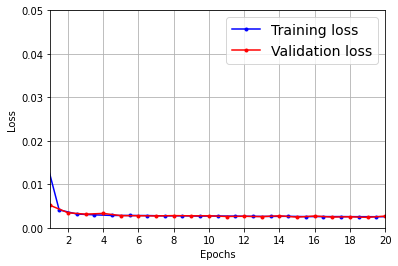

In [28]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [29]:
preferred_rnn_model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 7ms/step - loss: 0.0026 - mse: 0.0026


[0.0026162259746342897, 0.0026162259746342897]

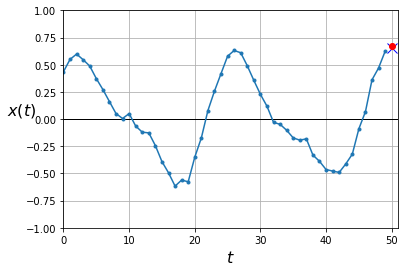

In [30]:
y_pred = preferred_rnn_model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Forecasting Several Time Steps Ahead:

In [31]:
series = generate_time_series(1, n_steps + 10)

In [32]:
series.shape

(1, 60, 1)

In [33]:
X_new, y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

for step_ahead in range(10):
    y_pred_one = preferred_rnn_model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

y_pred = X[:, n_steps:]
print(y_pred)

[[[-0.0668657 ]
  [-0.256701  ]
  [-0.4552129 ]
  [-0.63714045]
  [-0.75175816]
  [-0.76342237]
  [-0.67462456]
  [-0.5131946 ]
  [-0.32203364]
  [-0.14045508]]]


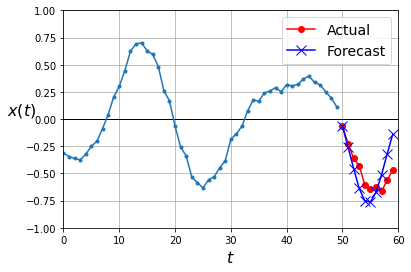

In [34]:
plot_multiple_forecasts(X_new, y_new, y_pred)
plt.show()

In [11]:
series = generate_time_series(10000, n_steps + 10)
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [58]:
model_last_10 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model_last_10.compile(loss="mse",
              optimizer="nadam",
              metrics=["mse"])
model_last_10.fit(X_train, y_train, epochs=50,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/50
219/219 [==============================] - 16s 67ms/step - loss: 0.1047 - mse: 0.1047 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 2/50
219/219 [==============================] - 14s 62ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0172 - val_mse: 0.0172
Epoch 3/50
219/219 [==============================] - 14s 63ms/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0197 - val_mse: 0.0197
Epoch 4/50
219/219 [==============================] - 14s 64ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 5/50
219/219 [==============================] - 14s 62ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 6/50
219/219 [==============================] - 14s 62ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 7/50
219/219 [==============================] - 13s 62ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 8/50
219/219 [==============================] - 13s 61ms

In [59]:
model_last_10 = keras.models.load_model("Best_simple_RNN.h5")
y_valid_pred = model_last_10.predict(X_valid)
y_valid_pred.shape

(2000, 10)

In [37]:
series = generate_time_series(1, 50 + 10)
X_new, y_new = series[:, :50, :], series[:, -10:, :]

In [38]:
series.shape

(1, 60, 1)

In [39]:
y_pred = model_last_10.predict(X_new)[..., np.newaxis]

In [40]:
y_pred.shape

(1, 10, 1)

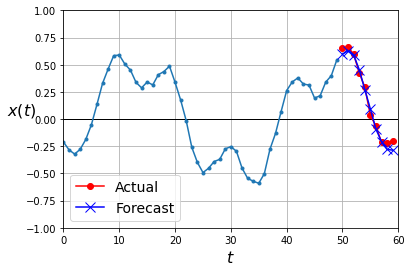

In [41]:
plot_multiple_forecasts(X_new, y_new, y_pred)
plt.show()

In [12]:
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[: ,step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [13]:
Y_valid.shape

(2000, 50, 10)

In [87]:
time_dist_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

time_dist_model.compile(loss="mse",
              optimizer=keras.optimizers.Nadam(lr=4e-4),
              metrics=["mse"])

time_dist_model.fit(X_train, Y_train, epochs=10,
          validation_data=(X_valid, Y_valid),
          callbacks=callbacks)

Epoch 1/10
219/219 [==============================] - 15s 64ms/step - loss: 0.2172 - mse: 0.2172 - val_loss: 0.0661 - val_mse: 0.0661
Epoch 2/10
219/219 [==============================] - 14s 63ms/step - loss: 0.0608 - mse: 0.0608 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 3/10
219/219 [==============================] - 14s 65ms/step - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 4/10
219/219 [==============================] - 13s 61ms/step - loss: 0.0473 - mse: 0.0473 - val_loss: 0.0454 - val_mse: 0.0454
Epoch 5/10
219/219 [==============================] - 13s 61ms/step - loss: 0.0450 - mse: 0.0450 - val_loss: 0.0440 - val_mse: 0.0440
Epoch 6/10
219/219 [==============================] - 13s 61ms/step - loss: 0.0438 - mse: 0.0438 - val_loss: 0.0425 - val_mse: 0.0425
Epoch 7/10
219/219 [==============================] - 14s 63ms/step - loss: 0.0424 - mse: 0.0424 - val_loss: 0.0413 - val_mse: 0.0413
Epoch 8/10
219/219 [==============================] - 13s 61ms

In [88]:
time_dist_model = keras.models.load_model("Best_simple_RNN.h5")
time_dist_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_16 (SimpleRNN)    (None, None, 20)          440       
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, None, 20)          820       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 10)          210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [89]:
X_valid[np.newaxis, 0].shape

(1, 50, 1)

In [90]:
Y_pred = time_dist_model.predict(X_test[np.newaxis, 0])

In [91]:
print(Y_pred.shape)
Y_test[0].shape

(1, 50, 10)


(50, 10)

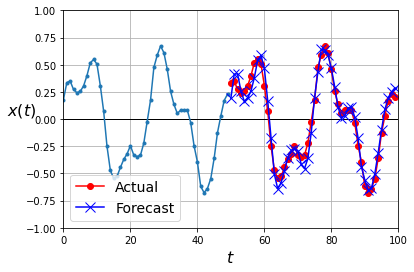

In [92]:
plot_multiple_forecasts(X_test[np.newaxis, 0], Y_test[np.newaxis, 0], Y_pred)

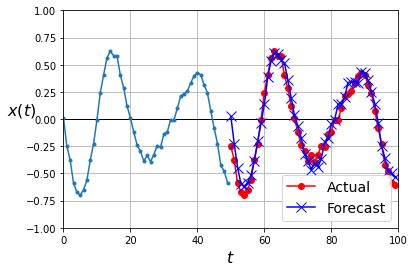

In [93]:
Y_pred = time_dist_model.predict(X_test[np.newaxis, 1])
plot_multiple_forecasts(X_test[np.newaxis, 1], Y_test[np.newaxis, 1], Y_pred)

#### Using Last Time-Step mse:

In [155]:
X_train.shape

(7000, 50, 1)

In [15]:
class last_time_step_mse(keras.metrics.Metric):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.metric_val = None

    def update_state(self, Y_true, Y_pred, sample_weight=None):
        self.metric_val = keras.metrics.mean_squared_error(Y_true[:, -1],
                                                           Y_pred[:, -1]),
        
    def result(self):
        return self.metric_val
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

In [159]:
def last_time_step_mse_func(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

custom_metric_time_dist_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

custom_metric_time_dist_model.compile(loss="mse",
                                      optimizer=keras.optimizers.Nadam(lr=4e-4),
                                      metrics=[last_time_step_mse()])

custom_metric_time_dist_model.summary()

custom_metric_time_dist_model.fit(X_train, Y_train, epochs=50,
                                  validation_data=(X_valid, Y_valid),
                                  callbacks=callbacks,
                                  batch_size=25)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_28 (SimpleRNN)    (None, None, 20)          440       
_________________________________________________________________
simple_rnn_29 (SimpleRNN)    (None, None, 20)          820       
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 10)          210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
280/280 [==============================] - 12s 40ms/step - loss: 0.1599 - last_time_step_mse_90: 0.0950 - val_loss: 0.0540 - val_last_time_step_mse_90: 0.0376
Epoch 2/50
280/280 [==============================] - 11s 40ms/step - loss: 0.0510 - last_time_step_mse_90: 0.0362 - val_loss: 0.0456 - val_last_time_step_mse_90: 0.0283
Epoch 3/50
280/280 [=====================

In [160]:
custom_metric_time_dist_model = keras.models.load_model("Best_simple_RNN.h5", custom_objects={"last_time_step_mse": last_time_step_mse})
custom_metric_time_dist_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_28 (SimpleRNN)    (None, None, 20)          440       
_________________________________________________________________
simple_rnn_29 (SimpleRNN)    (None, None, 20)          820       
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 10)          210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [161]:
custom_metric_time_dist_model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 7ms/step - loss: 0.0249 - last_time_step_mse_90: 0.0143


[0.02494640462100506,
 array([[0.01264034, 0.01837436, 0.00497416, 0.02088312, 0.03082954,
         0.00202748, 0.01654735, 0.00783085]], dtype=float32)]

### Layer Normalization:    

In [40]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

    def get_config(self):
        base_config = super().get_config()
        return {**base_config,
                "units": self.state_size,
                "activation": keras.activations.get(self.activation)}

In [25]:
ln_model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

ln_model.compile(loss="mse",
                 optimizer=keras.optimizers.Nadam(4e-4),
                 metrics=[last_time_step_mse()])

ln_model.fit(X_train, Y_train, epochs=20,
             validation_data=(X_valid, Y_valid),
             callbacks=callbacks,
             batch_size=25)

Epoch 1/20
280/280 [==============================] - 21s 68ms/step - loss: 0.3148 - last_time_step_mse_3: 0.1572 - val_loss: 0.0797 - val_last_time_step_mse_3: 0.0592
Epoch 2/20
280/280 [==============================] - 21s 75ms/step - loss: 0.0697 - last_time_step_mse_3: 0.0473 - val_loss: 0.0551 - val_last_time_step_mse_3: 0.0401
Epoch 3/20
280/280 [==============================] - 21s 75ms/step - loss: 0.0534 - last_time_step_mse_3: 0.0369 - val_loss: 0.0470 - val_last_time_step_mse_3: 0.0254
Epoch 4/20
280/280 [==============================] - 20s 71ms/step - loss: 0.0460 - last_time_step_mse_3: 0.0302 - val_loss: 0.0417 - val_last_time_step_mse_3: 0.0207
Epoch 5/20
280/280 [==============================] - 21s 75ms/step - loss: 0.0410 - last_time_step_mse_3: 0.0246 - val_loss: 0.0391 - val_last_time_step_mse_3: 0.0185
Epoch 6/20
280/280 [==============================] - 21s 76ms/step - loss: 0.0388 - last_time_step_mse_3: 0.0214 - val_loss: 0.0362 - val_last_time_step_mse_3:

In [26]:
ln_model = keras.models.load_model("Best_simple_RNN.h5",
                                   custom_objects={"LNSimpleRNNCell": LNSimpleRNNCell,
                                                   "last_time_step_mse": last_time_step_mse})
ln_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_10 (RNN)                 (None, None, 20)          480       
_________________________________________________________________
rnn_11 (RNN)                 (None, None, 20)          860       
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 10)          210       
Total params: 1,550
Trainable params: 1,550
Non-trainable params: 0
_________________________________________________________________


### Custom RNN Class:

In [71]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False,**kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs

    def get_config(self):
        base_config = super().get_config()
        return {**base_config,
                "cell": self.cell,
                "return_sequences":self.return_sequences}

In [72]:
custom_rnn_model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

custom_rnn_model.compile(loss="mse",
                         optimizer=keras.optimizers.Nadam(lr=4e-4),
                         metrics=[last_time_step_mse()])

custom_rnn_model.fit(X_train, Y_train, epochs=20,
                     validation_data=(X_valid, Y_valid),
                     callbacks=callbacks,
                     batch_size=n_steps)

Epoch 1/20
140/140 [==============================] - 21s 138ms/step - loss: 0.5117 - last_time_step_mse_14: 0.3930 - val_loss: 0.2189 - val_last_time_step_mse_14: 0.2226
Epoch 2/20
140/140 [==============================] - 20s 141ms/step - loss: 0.1879 - last_time_step_mse_14: 0.1632 - val_loss: 0.1352 - val_last_time_step_mse_14: 0.1285
Epoch 3/20
140/140 [==============================] - 18s 132ms/step - loss: 0.1255 - last_time_step_mse_14: 0.1070 - val_loss: 0.0973 - val_last_time_step_mse_14: 0.0885
Epoch 4/20
140/140 [==============================] - 19s 133ms/step - loss: 0.0921 - last_time_step_mse_14: 0.0768 - val_loss: 0.0789 - val_last_time_step_mse_14: 0.0724
Epoch 5/20
140/140 [==============================] - 19s 135ms/step - loss: 0.0773 - last_time_step_mse_14: 0.0635 - val_loss: 0.0703 - val_last_time_step_mse_14: 0.0622
Epoch 6/20
140/140 [==============================] - 18s 129ms/step - loss: 0.0691 - last_time_step_mse_14: 0.0562 - val_loss: 0.0652 - val_last

In [73]:
custom_rnn_model = keras.models.load_model("Best_simple_RNN.h5",
                                           custom_objects={"MyRNN": MyRNN,
                                                           "LNSimpleRNNCell": LNSimpleRNNCell,
                                                           "last_time_step_mse": last_time_step_mse})
custom_rnn_model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_rnn_48 (MyRNN)            (None, None, 20)          480       
_________________________________________________________________
my_rnn_49 (MyRNN)            (None, None, 20)          860       
_________________________________________________________________
time_distributed_30 (TimeDis (None, None, 10)          210       
Total params: 1,550
Trainable params: 1,550
Non-trainable params: 0
_________________________________________________________________


### Short-Term Memory Problem:



#### LSTM Cells:

In [76]:
lstm_model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10)),
])

lstm_model.compile(loss="mse",
                   optimizer=keras.optimizers.Nadam(),
                   metrics=[last_time_step_mse()])

In [78]:
lstm_cell_model = keras.models.Sequential([
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

lstm_cell_model.compile(loss="mse",
                        optimizer=keras.optimizers.Nadam(),
                        metrics=[last_time_step_mse()])

#### GRU Cells:

In [82]:
gru_model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10)),
])

gru_model.compile(loss="mse",
                  optimizer=keras.optimizers.Nadam(lr=4e-4),
                  metrics=[last_time_step_mse()])

gru_model.fit(X_train, Y_train, epochs=20,
              validation_data=(X_valid, Y_valid),
              callbacks=callbacks,
              batch_size=50)

Epoch 1/20
140/140 [==============================] - 4s 12ms/step - loss: 0.1356 - last_time_step_mse_19: 0.1085 - val_loss: 0.0721 - val_last_time_step_mse_19: 0.0630
Epoch 2/20
140/140 [==============================] - 1s 8ms/step - loss: 0.0678 - last_time_step_mse_19: 0.0532 - val_loss: 0.0602 - val_last_time_step_mse_19: 0.0451
Epoch 3/20
140/140 [==============================] - 1s 8ms/step - loss: 0.0588 - last_time_step_mse_19: 0.0453 - val_loss: 0.0546 - val_last_time_step_mse_19: 0.0378
Epoch 4/20
140/140 [==============================] - 1s 8ms/step - loss: 0.0531 - last_time_step_mse_19: 0.0408 - val_loss: 0.0504 - val_last_time_step_mse_19: 0.0341
Epoch 5/20
140/140 [==============================] - 1s 8ms/step - loss: 0.0490 - last_time_step_mse_19: 0.0372 - val_loss: 0.0471 - val_last_time_step_mse_19: 0.0310
Epoch 6/20
140/140 [==============================] - 1s 8ms/step - loss: 0.0465 - last_time_step_mse_19: 0.0344 - val_loss: 0.0449 - val_last_time_step_mse_19

In [84]:
gru_model = keras.models.load_model("Best_simple_RNN.h5",
                                    custom_objects={"last_time_step_mse": last_time_step_mse})
gru_model.summary()
gru_model.evaluate(X_test, Y_test)

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, None, 20)          1380      
_________________________________________________________________
gru_5 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
time_distributed_38 (TimeDis (None, None, 10)          210       
Total params: 4,110
Trainable params: 4,110
Non-trainable params: 0
_________________________________________________________________
32/32 [==============================] - 1s 4ms/step - loss: 0.0282 - last_time_step_mse_19: 0.0180


[0.028194382786750793,
 array([[0.00736484, 0.00421599, 0.01911667, 0.03976   , 0.00367124,
         0.01381262, 0.0174726 , 0.03823227]], dtype=float32)]

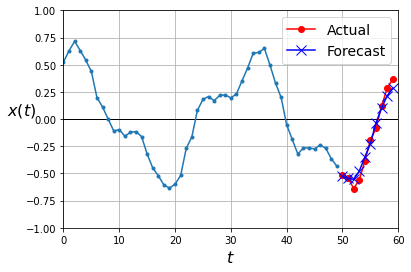

In [87]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = gru_model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Excercise:

In [35]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import tarfile
import requests
import urllib
import zipfile

### 10.

In [53]:
!pip install py_midicsv
import py_midicsv as pm 
import csv

In [36]:
# http://www-etud.iro.umontreal.ca/~boulanni/JSB%20Chorales.zip
url = "http://www-etud.iro.umontreal.ca/~boulanni/JSB%20Chorales.zip"
target_path = "/content/JSB_chorales.zip"
os.makedirs("./chorales", exist_ok=True)

urllib.request.urlretrieve(url, target_path)
with zipfile.ZipFile(target_path, 'r') as zip_ref:
    zip_ref.extractall("./chorales")

In [39]:
csv_data_root_path = "./chorales_csv/"
os.makedirs(csv_data_root_path, exist_ok=True)
PATHS = []
set_types = ("train/", "valid/", "test/")

for set_type in set_types:
    set_path = csv_data_root_path + set_type
    os.makedirs(set_path, exist_ok=True)
    PATHS.append(set_path)

In [52]:
##        24 important number

In [64]:
def first_element_extractor(item):
    return 

for root, dirs, files in os.walk("./chorales/JSB Chorales"):
    for filename in files:
        csv_string = pm.midi_to_csv(f'{root}/{filename}')
        csv_string = [item.split(" ") for item in csv_string]
        csv_string = list(map(lambda item: [element[:-1] for element in item], csv_string))
        with open(f'./chorales_csv/{root[24:]}/{filename[:-3]}csv', "w") as csv_file:
            csvwriter = csv.writer(csv_file)
            csvwriter.writerow(csv_string)

[['0', '0', 'Header', '0', '1', '100'], ['1', '0', 'Start_track'], ['1', '0', 'Program_c', '0', '0'], ['1', '0', 'Note_on_c', '0', '60', '90'], ['1', '0', 'Note_on_c', '0', '63', '90'], ['1', '0', 'Note_on_c', '0', '67', '90'], ['1', '0', 'Note_on_c', '0', '72', '90'], ['1', '120', 'Note_off_c', '0', '63', '0'], ['1', '120', 'Note_on_c', '0', '75', '90'], ['1', '240', 'Note_off_c', '0', '60', '0'], ['1', '240', 'Note_off_c', '0', '72', '0'], ['1', '240', 'Note_off_c', '0', '75', '0'], ['1', '240', 'Note_on_c', '0', '71', '90'], ['1', '240', 'Note_on_c', '0', '74', '90'], ['1', '360', 'Note_off_c', '0', '67', '0'], ['1', '360', 'Note_off_c', '0', '71', '0'], ['1', '360', 'Note_off_c', '0', '74', '0'], ['1', '360', 'Note_on_c', '0', '56', '90'], ['1', '360', 'Note_on_c', '0', '63', '90'], ['1', '360', 'Note_on_c', '0', '72', '90'], ['1', '480', 'Note_off_c', '0', '63', '0'], ['1', '480', 'Note_on_c', '0', '65', '90'], ['1', '600', 'Note_off_c', '0', '56', '0'], ['1', '600', 'Note_off_c',

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

